In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Question 1

In [107]:
sales = pd.read_csv('sales.csv', index_col=0)

### EDA

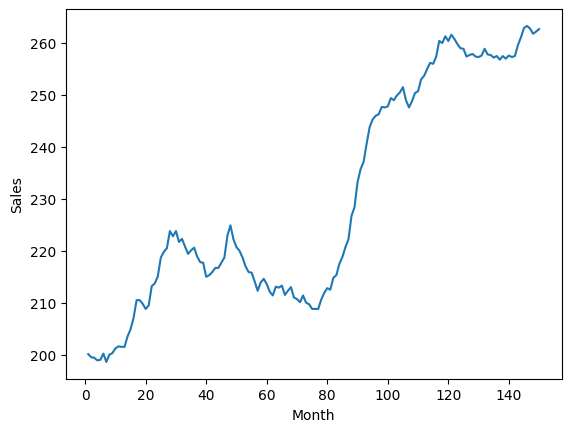

In [108]:
plt.plot(sales)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

We see a strong, postitive trend indiciating non-stationarity.

### Transformations

Lets attempt to remove the trend by transforming the data.

In [109]:
log_sales = np.log(sales)
dlog_sales = np.log(sales).diff()

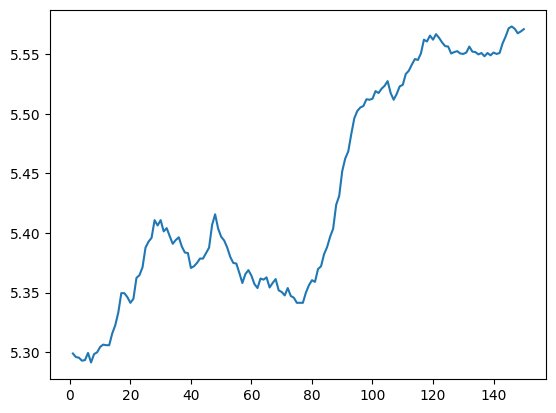

In [110]:
plt.plot(log_sales)
plt.show()

That changes the scale but did not remove the trend. Now let's try differencing:

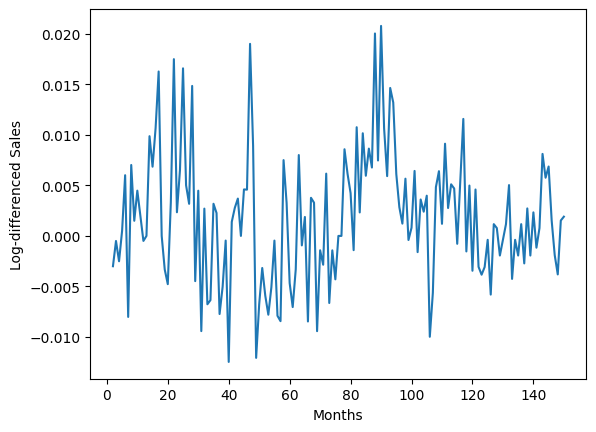

In [111]:
plt.plot(dlog_sales)
plt.ylabel('Log-differenced Sales')
plt.xlabel('Months')
plt.show()

While not perfect, this seems to have removed much of the trend.

Lets try differencing again:

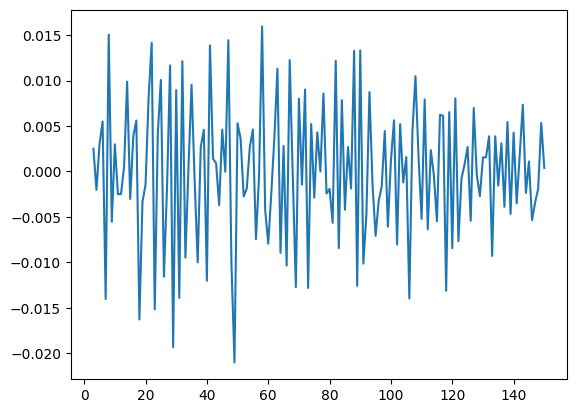

In [112]:
ddlog_sales = dlog_sales.diff()

plt.plot(ddlog_sales)
plt.show()

This looks very similar to IID noise, indicating that the transformations and differencing helped remove the trend and much of the non-constant variance.

### Identification of orders

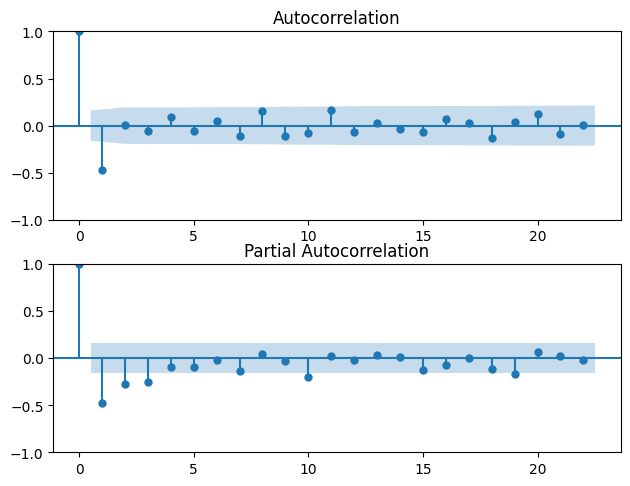

In [113]:
fig, ax = plt.subplots(2,1)
fig.tight_layout()
plot_acf(ddlog_sales.dropna(), ax=ax[0]);
plot_pacf(ddlog_sales.dropna(),ax=ax[1]);

We see evidence of an MA(1) and AR(3) based on the significant ACF at lag 1, and significant PACF at lags 1,2,3.

### Parameter Estimation

In [114]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

model = ARIMA(endog=log_sales, order=(1,2,1));
res = model.fit();
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  150
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 544.558
Date:                Wed, 28 Feb 2024   AIC                          -1083.116
Time:                        10:43:07   BIC                          -1074.124
Sample:                             0   HQIC                         -1079.463
                                - 150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0402      0.112      0.359      0.719      -0.179       0.259
ma.L1         -0.7165      0.071    -10.119      0.000      -0.855      -0.578
sigma2      3.707e-05    4.1e-06      9.033      0.000     2.9e-05    4.51e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.52   Prob(JB):                         0.67
Heteroskedasticity (H):               0.35   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

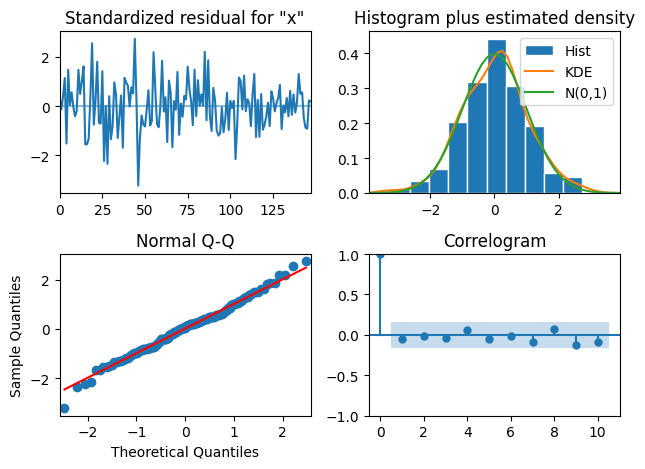

In [115]:
fig = plt.figure()
res.plot_diagnostics(fig=fig)
fig.tight_layout()

From the above diagnostic plots we can make the following conclusions:
- Residuals seem to be IID
- Residuals seem to be normally distributed (but with heavy tails)

Together, these observations seems to indicate that the ARIMA(3,2,1) model is a solid fit to our sales data.

# Question 2

In [116]:
lead = pd.read_csv('lead.csv', index_col=0)

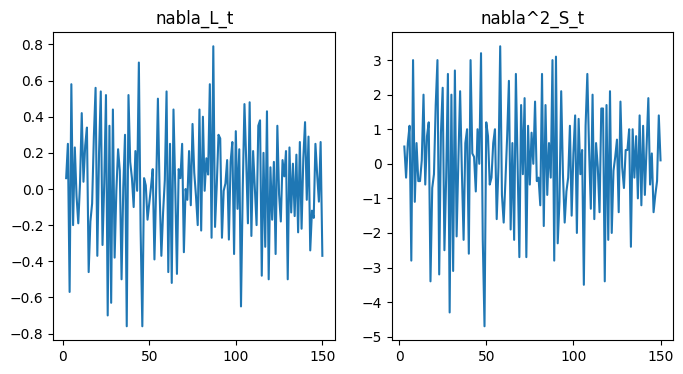

In [117]:
nabla_L_t = lead.diff().dropna()
nabla_S_t = sales.diff().diff().dropna()

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot(nabla_L_t)
ax[0].set_title('nabla_L_t')
ax[1].plot(nabla_S_t)
ax[1].set_title('nabla^2_S_t')
plt.show()

From the above plots, we can conclude that both $\nabla L_{t-3}$ and $\nabla^2 S_t$ are stationary.

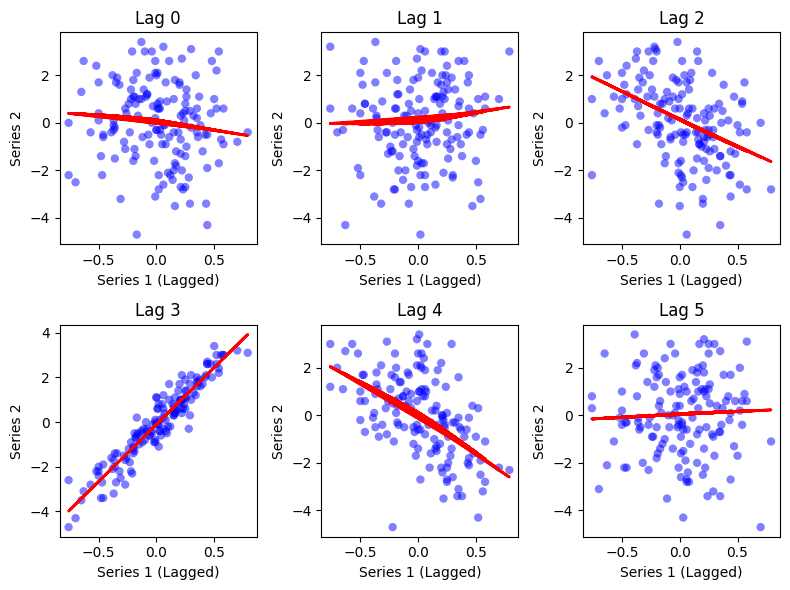

In [118]:
# Here we create scatterplots of Nabla^2_S_t vs Nabla_L_t-h for different values
# of h

from statsmodels.nonparametric.smoothers_lowess import lowess

series1 = nabla_L_t
series2 = nabla_S_t
max_lag = 5

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
axes = axes.flatten()

for lag in range(max_lag + 1):
    # Create lagged series
    series1_lagged = series1.shift(lag)

    # Align series by index, dropping unmatched indices
    aligned_df = pd.concat([series1_lagged, series2], axis=1, join='inner')

    # Calculate the lowess smoothed curve
    smoothed = lowess(
        endog=aligned_df.iloc[:, 1],  # y-values are the second series
        exog=aligned_df.iloc[:, 0],   # x-values are the lagged series
        frac=1,
        return_sorted=False
    )

    # Scatter plot
    axes[lag].scatter(aligned_df.iloc[:, 0], aligned_df.iloc[:, 1], alpha=0.5, color='blue', edgecolor='none')

    # Plot the lowess smoothed line
    axes[lag].plot(aligned_df.iloc[:, 0], smoothed, color='red', linewidth=2)
    
    axes[lag].set_title(f'Lag {lag}')
    axes[lag].set_xlabel(f'Series 1 (Lagged)')
    axes[lag].set_ylabel('Series 2')

plt.tight_layout()
plt.show()

We can see that there is a strong, linear relationship between $\nabla L_{t-3}$ and $\nabla S_t$ in the bottom left plot.

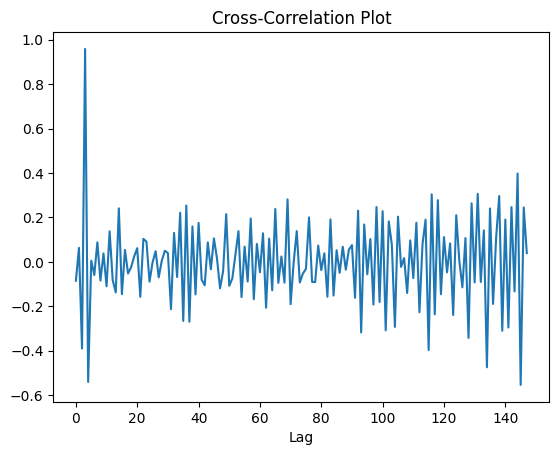

In [119]:
from statsmodels.tsa.stattools import ccf

cross_corr = ccf(nabla_S_t,nabla_L_t[1:])
plt.plot(cross_corr)
plt.title('Cross-Correlation Plot')
plt.xlabel('Lag')
plt.show()

We can see from the ccf plot that there is strong indication of cross-correlation at a lag of 3.

Based on the above conclusions, it is reasonable to explore a regression on $\nabla L_{t-3}$ and $\nabla S_t$

# Question 3

In [122]:
import statsmodels.api as sm

nabla_L_t_minus_3 = lead.diff().shift(3).dropna()

df = pd.concat([nabla_S_t,nabla_L_t_minus_3.rename(columns={'x':'l'})], axis=1).dropna().rename(columns={'x':'s'})

X = df['l']
Y = df['s']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      s   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1238.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           1.36e-72
Time:                        10:43:11   Log-Likelihood:                -119.79
No. Observations:                 146   AIC:                             243.6
Df Residuals:                     144   BIC:                             249.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1178      0.046     -2.565      0.011      -0.209      -0.027
l              5.0997      0.145     35.184      0.000       4.813       5.386
==============================================================================
Omnibus:                        0.505   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.230
Skew:                          -0.068   Prob(JB):                        0.891
Kurtosis:                       3.140   Cond. No.                         3.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

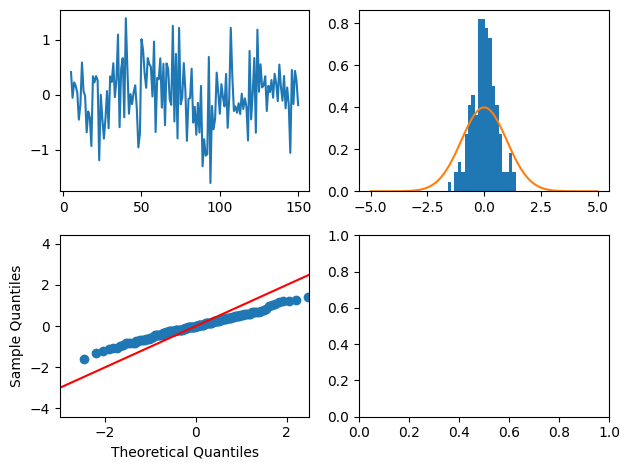

In [123]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

fig, ax = plt.subplots(2,2)
ax[0,0].plot(model.resid)

qqplot(model.resid, ax=ax[1,0]);
ax[1,0].plot([-4,4],[-4,4],color='r')
ax[1,0].set_xlim(-3,2.5)

ax[0,1].hist(model.resid, bins=20, density=True)
x = np.linspace(-5, 5, 100)
p = norm.pdf(x, 0, 1)
ax[0,1].plot(x,p)

fig.tight_layout()
plt.show()

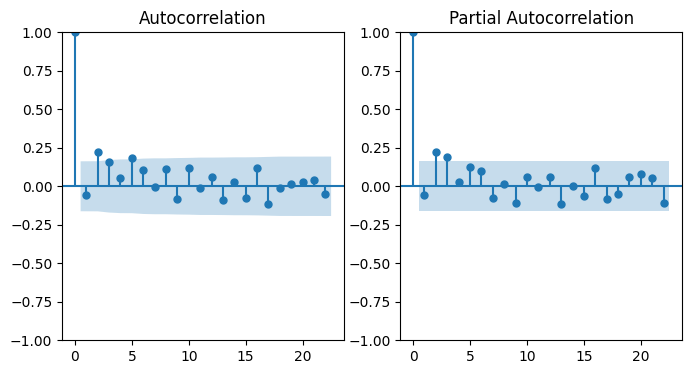

In [124]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
plot_acf(model.resid, ax=ax[0]);
plot_pacf(model.resid, ax=ax[1]);

Given that the $R^2$ of the initial model is almost .9, and that the residuals do not have a clear ARMA form (based on ACF, PACF), I will not impliment an additional ARMA model on the residuals.

In [125]:
# # Fit x_t to an ARMA(3,1)
# resid_model = ARIMA(model.resid, order=(3,0,1)).fit()
# resid_model.summary()

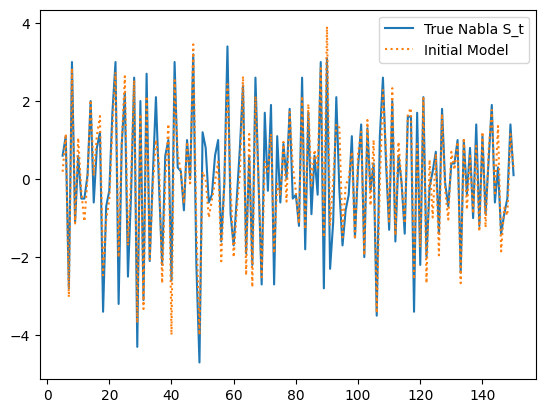

In [126]:
plt.plot(df['s'], label='True Nabla S_t')
plt.plot(model.fittedvalues, label='Initial Model', ls=':')
# plt.plot(model.fittedvalues + resid_model.fittedvalues, label='Final Model Prediction', ls='--', alpha=.5)
plt.legend()
plt.show()

**Conclusions:** We see a very good fit for the regression of $\nabla S_t$ on $\nabla L_{t-3}$. This is shown by a very high $R^2$ of .9 and by examining the true vs predicted plot shown directly above. Additionally, the ACF and PACF of the model residuals were examined, and it was concluded that there was insufficient evidence to warrant fitting an addtitional ARMA model to them.